# Download some text files

In [3]:
import os
import json
import kagglehub  # pip install kagglehub

# Download files with song lyrics from Kaggle.
# Save them to `lyrics_path`
lyrics_path = kagglehub.dataset_download("paultimothymooney/poetry")
print(f"Data downloaded to {lyrics_path}")

Data downloaded to /home/nick/.cache/kagglehub/datasets/paultimothymooney/poetry/versions/16


In [4]:
lyrics_files = os.listdir(lyrics_path)
print(f"{len(lyrics_files)} .txt files downloaded.")

49 .txt files downloaded.


In [5]:
lyrics_files[0:3]

['r-kelly.txt', 'amy-winehouse.txt', 'adele.txt']

# Convert text files to JSON format

In [6]:
# Create a directory `json_files`
os.makedirs("json_files", exist_ok=True)

In [7]:
for lyrics_file in lyrics_files:

    with open(file=os.path.join(lyrics_path, lyrics_file), mode="r") as f:
        text = f.read()

    temp_dict = [{"text": text}]
    json_path = os.path.join("json_files", lyrics_file)

    json_path = json_path[:-4] + ".json" # remove .txt and add .json
    with open(json_path, 'w') as fp:
        json.dump(temp_dict, fp)

# Create Dataset from JSON files

In [8]:
from llm_trainer import create_dataset_from_json

create_dataset_from_json(save_dir="data",
                         json_dir="json_files",
                         chunk_size=int(1e5),
                         chunk_limit=1500)

Processing Chunks:   1%|          | 18/1500 [00:00<01:14, 20.01chunk/s]


# Train GPT2 model on this data

In [9]:
from transformers import GPT2Config, GPT2LMHeadModel

model = GPT2LMHeadModel(config=GPT2Config(n_positions=256, n_embd=512, n_head=8))

# Print the size of the model (a number of parameters it has) in millions.
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {num_params / 1e6:.2f}M")

Total Parameters: 63.69M


In [10]:
from llm_trainer import LLMTrainer

trainer = LLMTrainer(model=model)
trainer.train(BATCH_SIZE=512, generate_each_n_steps=100, max_steps=200, prompt="Every time we say goodbye,\nI die a little")

W0312 20:20:42.072000 2184 site-packages/torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


step: 0 | Loss: 10.687500 | norm: 14.4388 | lr: 2.000000e-05 | dt: 37.14s | tok/sec: 3528.78
step: 1 | Loss: 10.062500 | norm: 7.3094 | lr: 2.666667e-05 | dt: 3.42s | tok/sec: 38283.97
step: 2 | Loss: 10.000000 | norm: 4.1528 | lr: 3.333333e-05 | dt: 3.41s | tok/sec: 38385.10
step: 3 | Loss: 10.000000 | norm: 2.9891 | lr: 4.000000e-05 | dt: 3.42s | tok/sec: 38376.03
step: 4 | Loss: 9.937500 | norm: 5.0828 | lr: 4.666667e-05 | dt: 3.45s | tok/sec: 37990.83
step: 5 | Loss: 9.875000 | norm: 2.7775 | lr: 5.333333e-05 | dt: 3.48s | tok/sec: 37713.29
step: 6 | Loss: 9.937500 | norm: 3.0434 | lr: 6.000000e-05 | dt: 3.50s | tok/sec: 37439.81
step: 7 | Loss: 9.875000 | norm: 2.4737 | lr: 6.666667e-05 | dt: 3.42s | tok/sec: 38307.88
step: 8 | Loss: 9.937500 | norm: 2.3718 | lr: 7.333333e-05 | dt: 3.41s | tok/sec: 38465.96
step: 9 | Loss: 9.812500 | norm: 2.3731 | lr: 8.000000e-05 | dt: 3.41s | tok/sec: 38478.96
step: 10 | Loss: 9.812500 | norm: 2.3739 | lr: 8.666667e-05 | dt: 3.50s | tok/sec: 37

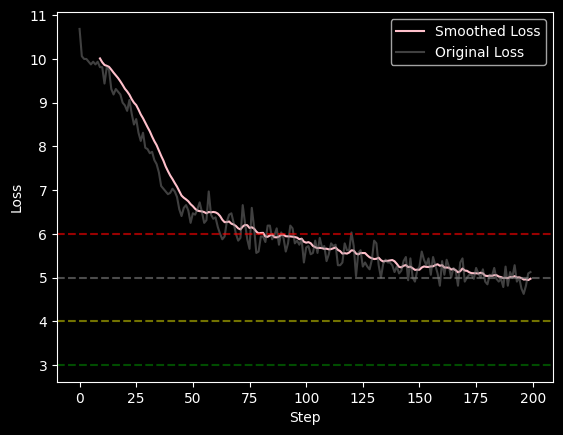

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# DISPLAY LOSS
data = pd.read_csv("logs_training.csv")

window_size = 10  # Adjust for more or less smoothing
smoothed_loss = data["Loss"].rolling(window=window_size).mean()

plt.plot(data["Step"], smoothed_loss, label="Smoothed Loss", color="pink")
plt.plot(data["Step"], data["Loss"], alpha=0.5, label="Original Loss", color="gray")

plt.axhline(y=6, color='r', linestyle='--', alpha=0.6)
plt.axhline(y=5, color='gray', linestyle='--', alpha=0.6)
plt.axhline(y=4, color='y', linestyle='--', alpha=0.6)
plt.axhline(y=3, color='g', linestyle='--', alpha=0.6)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()